<a href="https://colab.research.google.com/github/SalasNorman/workshop/blob/main/iris/iris_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Warning**: Iris dataset can't be use for regression.

* The Iris dataset is usually for classification, not regression.

* The target variable is species (setosa, versicolor, virginica), which is categorical.

* Regression is for predicting numbers, but classification is for predicting categories.

* You can use features like petal length for regression, but the dataset is designed for classification tasks.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# 1. Load Data
# Updated URL to the raw CSV file on GitHub
url = "https://raw.githubusercontent.com/SalasNorman/workshop/main/iris/iris_dataset.csv"  # Data URL
df = pd.read_csv(url)

In [3]:
# Drop the unnecessary 'Id' column
df.drop(columns=['Id'], inplace=True)

In [4]:
# Check for duplicates and drop if necessary
df.drop_duplicates(inplace=True)

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa


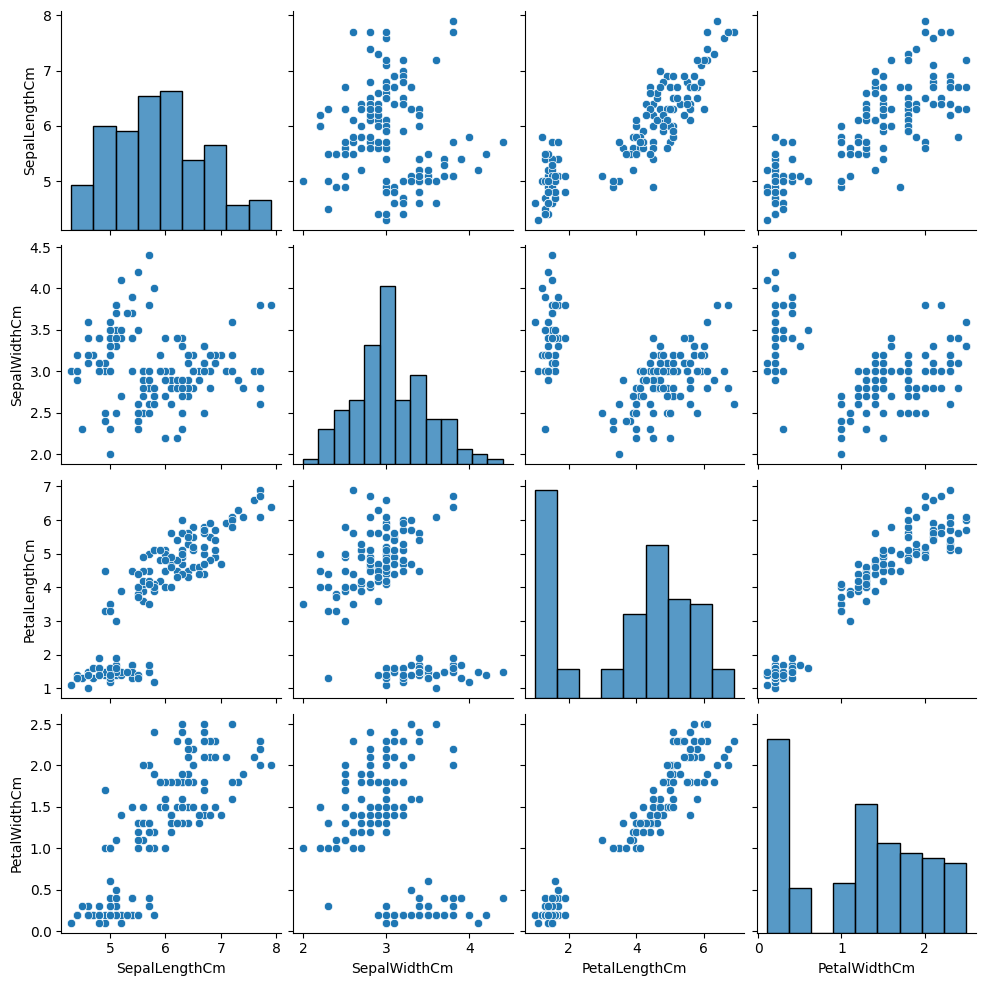

In [5]:
# Basic EDA (optional)
print(df.head())
sns.pairplot(df.drop(columns=['Species']))
plt.show()

In [6]:
# 2. Pre-processing for Regression
# We'll predict "SepalLengthCm" using other numerical features.
X = df.drop(columns=['SepalLengthCm', 'Species'])
y = df['SepalLengthCm']

In [7]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Standardize features.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# 3. Define models and hyperparameter grids

# For Linear Regression, no hyperparameters to tune but we will perform cross-validation.
lr = LinearRegression()

ridge = Ridge()
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100]}

lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100]}

tree = DecisionTreeRegressor(random_state=42)
tree_params = {'max_depth': [None, 2, 4, 6, 8],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

forest = RandomForestRegressor(random_state=42)
forest_params = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 2, 4, 6, 8],
                 'min_samples_split': [2, 5, 10]}

In [10]:
# 4. Hyperparameter tuning using GridSearchCV
models = {
    "Linear Regression": (lr, {}),  # No parameters for tuning
    "Ridge Regression": (ridge, ridge_params),
    "Lasso Regression": (lasso, lasso_params),
    "Decision Tree Regression": (tree, tree_params),
    "Random Forest Regression": (forest, forest_params)
}

# We'll store the best (fitted) models in a new dictionary
best_models = {}
results = {}

for name, (model, params) in models.items():
    print(f"Processing {name}...")
    if params:  # Models with hyperparameters
        grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"  Best Parameters: {grid.best_params_}")
    else:
        # For Linear Regression, we use cross-validation scores and then fit the model.
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        print(f"  CV Mean MSE: {-scores.mean():.4f}")
        model.fit(X_train, y_train)
        best_model = model

    best_models[name] = best_model

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R^2": r2}
    print(f"  Test Mean Squared Error: {mse:.4f}")
    print(f"  Test R^2 Score: {r2:.4f}")
    print("-" * 40)

Processing Linear Regression...
  CV Mean MSE: 0.0914
  Test Mean Squared Error: 0.1288
  Test R^2 Score: 0.8433
----------------------------------------
Processing Ridge Regression...
  Best Parameters: {'alpha': 0.001}
  Test Mean Squared Error: 0.1288
  Test R^2 Score: 0.8433
----------------------------------------
Processing Lasso Regression...
  Best Parameters: {'alpha': 0.001}
  Test Mean Squared Error: 0.1288
  Test R^2 Score: 0.8434
----------------------------------------
Processing Decision Tree Regression...
  Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
  Test Mean Squared Error: 0.1738
  Test R^2 Score: 0.7886
----------------------------------------
Processing Random Forest Regression...
  Best Parameters: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 200}
  Test Mean Squared Error: 0.1408
  Test R^2 Score: 0.8287
----------------------------------------


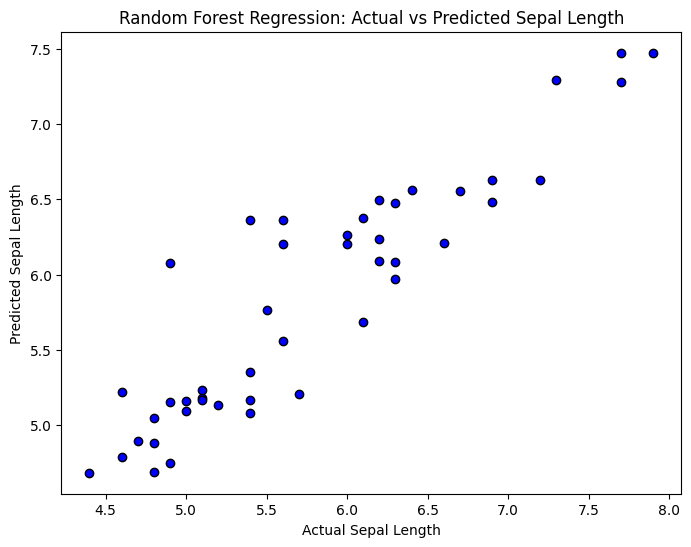

In [11]:
# 5. Optional: Visualize predictions for one model (e.g., Random Forest)
rf_best = best_models["Random Forest Regression"]
y_rf_pred = rf_best.predict(X_test)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_rf_pred, color='blue', edgecolors='k')
plt.xlabel('Actual Sepal Length')
plt.ylabel('Predicted Sepal Length')
plt.title('Random Forest Regression: Actual vs Predicted Sepal Length')
plt.show()

In [12]:
# Final summary of results:
print("\nSummary of Regression Model Performance:")
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.4f}, R^2 = {metrics['R^2']:.4f}")


Summary of Regression Model Performance:
Linear Regression: MSE = 0.1288, R^2 = 0.8433
Ridge Regression: MSE = 0.1288, R^2 = 0.8433
Lasso Regression: MSE = 0.1288, R^2 = 0.8434
Decision Tree Regression: MSE = 0.1738, R^2 = 0.7886
Random Forest Regression: MSE = 0.1408, R^2 = 0.8287
